In [2]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra

In [3]:
#Hyperparameters
n = 500;

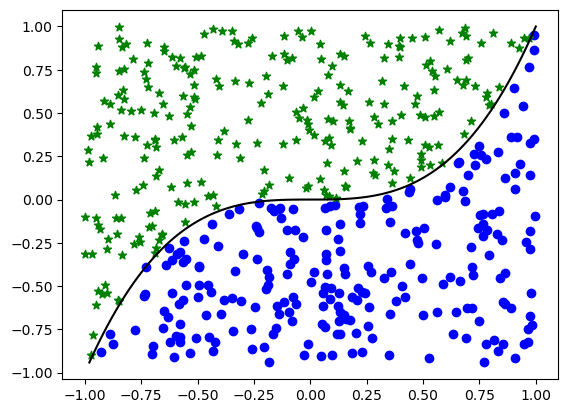

In [4]:
#Structure for generating some data and a discriminant polynomial
struct Poly
    β::Array{Float64}
    degree::Int
    x::Array{Float64}
    y::Array{Float64}
end

function fit_poly(f::Poly, x::Array)
    fitted_y = [sum([f.β[j]*x[i]^(j-1) for j=1:f.degree]) for i=1:length(x)]
    return fitted_y
end

function make_poly(β::Array{Float64}, N=5000::Int)
    degree = length(β)
    x = [2*(i/N - 0.5) for i=1:N]
    y = [sum([β[j]*x[i]^(j-1) for j=1:degree]) for i=1:length(x)]
    return(Poly(β, degree, x, y))
end

function plot_poly(f::Poly, c="black"::String, a=1.0::Float64,z=5::Int)
    plot(f.x, f.y, color=c,alpha=a,zorder=z)
end

function data_labeller(x::Array{Float64},y::Array{Float64},f::Poly)
    fitted_y = fit_poly(f, x)
    labels = [y[i] > fitted_y[i] ? 2 : 1 for i=1:length(x)]
    return labels
end

function make_data(f::Poly, N=5000::Int)
    a = minimum(f.y)
    b = maximum(f.y)
    x = rand(Uniform(-1,1),N)
    y = rand(Uniform(a,b),N)
    return (x,y)
end

function plot_data(x::Array{Float64},y::Array{Float64},f::Poly)
    labels = data_labeller(x,y,f)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [labels[j] == i for j in 1:length(y)]
        scatter(x[mask],y[mask],c=colors[i],marker=markers[i],zorder=3)
    end
    plot_poly(f)
end

function plot_accuracy(x::Array{Float64},y::Array{Float64},f::Poly,f_new::Poly)
    true_labels = data_labeller(x,y,f)
    pred_labels = data_labeller(x,y,f_new)
    correct = [pred_labels[i] == true_labels[i] for i in 1:length(x)]
    plot_poly(f)
    plot_poly(f_new, "blue")
    scatter(x,y,c=correct,cmap="Set1")
end

function sigmoid(x::Array{Float64})
    return 1.0 ./ (1.0 .+ exp.(-x))
end

β_test = [0.0,0.,-0.0,1.0]
f_test = make_poly(β_test, 100)
x_test, y_test = make_data(f_test, n)
plot_data(x_test,y_test,f_test)

function test_sigmoid(x::Array{Float64},y::Array{Float64},f)
    fitted = fit_poly(f,x)
    labels = data_labeller(x,y,f)
    differences = y - fitted
    println(sum(differences))
    scores = sigmoid(differences)
    scatter(differences, scores)
    classes = [scores[i] >= 0.5 ? 2 : 1 for i in 1:length(scores)]
    correct = [classes[i] == labels[i] for i in 1:length(classes)]
    println(sum(correct)/length(correct))
end;

In [6]:
#Generative function for discriminant polynomial
@gen function blr(x,y,f)
    σ = 1 #Sigma hyperparameter for drawing coefficients
    k = 4
    
    μ = zeros(k)
    Σ = Diagonal([σ for i=1:k])
    β ~ mvnormal(μ,Σ) #Coefficients of the polynomial
    
    f₂ = make_poly(β)
    fitted_values = fit_poly(f₂,x)
    differences = y - fitted_values
    scores = sigmoid(differences)

    z = zeros(length(x)) #Array to fill with class labels
    for j in 1:length(x)
        z[j] = @trace(categorical([1-scores[j],scores[j]]), (:z,j))
        #Draw class labels from Bernoulli distribution based on p = sigmoid(differences)
    end
    return z
end;

In [ ]:
labels = data_labeller(x_test,y_test,f_test)
obs = choicemap()::ChoiceMap
for j in 1:length(x_test)
    obs[(:z, j)] = labels[j]
end